# Variational Auto-Encoder

## VAE Overview

![vae](https://camo.githubusercontent.com/74620840800d49e0e3f0fb97db950212f61ec596/687474703a2f2f6b766672616e732e636f6d2f636f6e74656e742f696d616765732f323031362f30382f7661652e6a7067)

In [1]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/', one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
# parameters
learning_rate = 0.001
n_steps = 50000
display_steps = 1000
batch_size = 64

# network parameters
d_image = 784
d_hidden = 512 
d_latent = 2

In [5]:
# Variables
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

weights = {
    'encoder_h1': tf.Variable(glorot_init([d_image, d_hidden])),
    'z_mean': tf.Variable(glorot_init([d_hidden, d_latent])),
    'z_std': tf.Variable(glorot_init([d_hidden, d_latent])),
    'decoder_h1': tf.Variable(glorot_init([d_latent, d_hidden])),
    'decoder_out': tf.Variable(glorot_init([d_hidden, d_image]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([d_hidden])),
    'z_mean': tf.Variable(glorot_init([d_latent])),
    'z_std': tf.Variable(glorot_init([d_latent])),
    'decoder_b1': tf.Variable(glorot_init([d_hidden])),
    'decoder_out': tf.Variable(glorot_init([d_image]))
}

In [6]:
# building the encoder
X = tf.placeholder(tf.float32, [None, d_image])
encoder = tf.nn.tanh(
    tf.nn.xw_plus_b(X, weights['encoder_h1'], biases['encoder_b1'])
)
z_mean = tf.nn.xw_plus_b(encoder, weights['z_mean'], biases['z_mean'])
z_std = tf.nn.xw_plus_b(encoder, weights['z_std'], biases['z_std'])

# sampler: normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1., name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# building the decoder
decoder = tf.nn.tanh(
    tf.nn.xw_plus_b(z, weights['decoder_h1'], biases['decoder_b1'])
)
decoder = tf.nn.sigmoid(
    tf.nn.xw_plus_b(decoder, weights['decoder_out'], biases['decoder_out'])
)

In [7]:
# define VAE loss
def vae_loss(x_reconstructed, x_true):
    # reconstruction loss
    encoder_decoder_loss = -tf.reduce_sum(
        x_true * tf.log(1e-10 + x_reconstructed) + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed), axis=1
    )
    # KL divergence loss
    kl_div_loss = -0.5 * tf.reduce_sum(
        1 + z_std - tf.square(z_mean) - tf.exp(z_std), axis=1
    )
    return tf.reduce_mean(encoder_decoder_loss + kl_div_loss)

loss_op = vae_loss(decoder, X)

In [8]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

# training
for i in range(n_steps):
    batch_X, batch_y = mnist.train.next_batch(batch_size)
    
    sess.run(train_op, feed_dict={X: batch_X})
    
    if (i + 1) % display_steps == 0 or i == 0:
        print('step:', i + 1, 'loss:', sess.run(loss_op, feed_dict={X: batch_X}))

step: 1 loss: 633.10095
step: 1000 loss: 168.51672
step: 2000 loss: 154.95303
step: 3000 loss: 161.2189
step: 4000 loss: 167.60974
step: 5000 loss: 159.09581
step: 6000 loss: 158.79439
step: 7000 loss: 147.77444
step: 8000 loss: 153.67139
step: 9000 loss: 143.9216
step: 10000 loss: 144.17651
step: 11000 loss: 148.83763
step: 12000 loss: 144.01318
step: 13000 loss: 150.85638
step: 14000 loss: 146.73752
step: 15000 loss: 161.93776
step: 16000 loss: 144.56615
step: 17000 loss: 147.4663
step: 18000 loss: 128.75383
step: 19000 loss: 150.59003
step: 20000 loss: 153.49905
step: 21000 loss: 147.5105
step: 22000 loss: 145.6102
step: 23000 loss: 149.67584
step: 24000 loss: 143.01727
step: 25000 loss: 143.12454
step: 26000 loss: 143.36568
step: 27000 loss: 151.20651
step: 28000 loss: 148.51653
step: 29000 loss: 145.2627
step: 30000 loss: 154.68976
step: 31000 loss: 159.02744
step: 32000 loss: 144.71063
step: 33000 loss: 136.73592
step: 34000 loss: 138.47345
step: 35000 loss: 136.48846
step: 36000

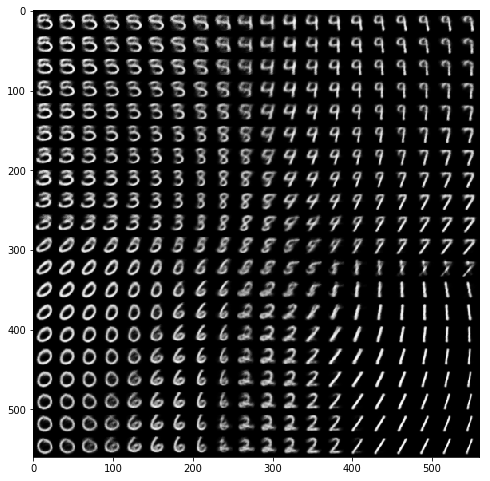

In [9]:
# testing
noise_input = tf.placeholder(tf.float32, [None, d_latent])
# rebuild the decoder to create image form noise
decoder = tf.nn.tanh(
    tf.nn.xw_plus_b(noise_input, weights['decoder_h1'], biases['decoder_b1'])
)
decoder = tf.nn.sigmoid(
    tf.nn.xw_plus_b(decoder, weights['decoder_out'], biases['decoder_out'])
)

# building a manifold of generated digits
n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28: (n - i) * 28, j * 28: (j + 1) *28] = x_mean[0].reshape(28, 28)
        
plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin='upper', cmap='gray')
plt.show()